###### Dimensionality Reduction Starter Coder 
# Version 6 includes TFIDF Cosine Similarity Starter Code
# Doc2Vec and Word2Vec
# TSNE visualization and K-Means document listings are provided to help you perform analysis
## 2021Spr_MSDS_453-DL_SEC56
### jennifer.sleeman@northwestern.edu, paulhuynh2018@u.northwestern.edu



In [1]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pandas as pd
import os
import numpy as np
import phrasemachine
from rake_nltk import Rake
import re
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
import gensim




In [2]:
#################################################################################
#An Example of One-hot encoding  
#Very Simple Based on example in Deep Learning for Natural Language Processing
#################################################################################
# define example
data = ['ginsburg', 'RBG', 'justice', 'ginsburg']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
print(onehot_encoded[0, :])
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

['ginsburg' 'RBG' 'justice' 'ginsburg']
[1 0 2 1]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[0. 1. 0.]
['ginsburg']


In [3]:
# Only run this once, they will be downloaded.
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulhuynh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulhuynh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [5]:
# Pre-process dataset to remove punctuation
def remove_punctuation(in_text):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(in_text))
    return text

In [6]:
# Pre-process dataset to lower case it
def lower_case(in_text):
    # Convert to lowercase
    text = in_text.lower()    
    return text

In [7]:
# Pre-process dataset to remove tags
def remove_tags(in_text):    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",in_text)
    return text

In [8]:
# Pre-process dataset to remove special characters and digits
def remove_special_chars_and_digits(in_text):
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",in_text)
    return text


In [9]:
# Pre-process dataset to appy Stemming
def apply_stemming(in_text):
    stemmer=PorterStemmer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([stemmer.stem(w) for w in word_list])
    return output

In [10]:
# Pre-process dataset to apply Lemmatization
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [11]:
# Remove stop words
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return filtered_sentence

In [12]:
# Run Phase Machine
def run_phrase_machine(in_text):
    phrases=phrasemachine.get_phrases(in_text)
    return phrases

In [13]:
#Run Rake Keyword Extractor
def run_rake(in_text):
    r = Rake()
    r.extract_keywords_from_text(in_text)
    rake_phrases= r.get_ranked_phrases()
    return rake_phrases

In [14]:
# Run NLTK Tokenizer
def run_nltk_tokenizer(in_text):
    tokens=nltk.word_tokenize(in_text)
    return tokens

In [15]:
# Run NLTK Sentence Tokenizer
def run_nltk_sent_tokenizer(in_corpus):
    sents = nltk.sent_tokenize(in_corpus)
    return sents

In [16]:
#Run word-ngram Tokenizer
def run_nltk_tokenizer_word_ngrams(in_text, ngram_size):
    n_grams = ngrams(nltk.word_tokenize(in_text), ngram_size)
    return [ ' '.join(grams) for grams in n_grams]

In [17]:
#Get Frequ Dist 
def get_freq_dist(terms):
    all_counts = dict()
    all_counts[size] = FreqDist(terms)
    return all_counts

In [18]:

###############################################################################
### Processing text into lists
###############################################################################
def get_corpus(path_to_file):
    #read in class corpus csv into python
    data=pd.read_csv(path_to_file)

    #create empty list to store text documents titles
    titles=[]
    docids=[]
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        docids.append(data['Doc_ID'].iloc[i])

    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        titles.append(data['DSI_Title'].iloc[i])

    #create empty list to store text documents
    text_body=[]

    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    return (docids,titles,text_body)

In [19]:
###############################################################################
### Functions to visualize documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    doc = ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)

    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    
    return tokens

def process_corpus(data):
        
    #create empty list to store text documents titles
    titles=[]
    
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        temp_text=data['DSI_Title'].iloc[i]
        titles.append(temp_text)
    
    #create empty list to store text documents
    text_body=[]
    
    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    
    #Note: the text_body is the unprocessed list of documents read directly form 
    #the csv.
        
    #empty list to store processed documents
    processed_text=[]
    #for loop to process the text to the processed_text list
    for i in text_body:
        text=clean_doc(i)
        processed_text.append(text)
    
    #Note: the processed_text is the PROCESSED list of documents read directly form 
    #the csv.  Note the list of words is separated by commas.
    
    
    #stitch back together individual words to reform body of text
    final_processed_text=[]
    
    for i in processed_text:
        temp_DSI=i[0]
        for k in range(1,len(i)):
            temp_DSI=temp_DSI+' '+i[k]
        final_processed_text.append(temp_DSI)
    
    return titles, final_processed_text, processed_text

def run_doc2vec(final_processed_text, processed_text):
    #create doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
    model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=4)    
    
    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
        
    return doc2vec_df

def run_word2vec(processed_text):

    #word to vec model
    model_w2v = Word2Vec(processed_text, size=100, window=3, min_count=2, workers=4)
    
    labels = []
    tokens = []

    for word in model_w2v.wv.vocab:
        tokens.append(model_w2v[word])
        labels.append(word)
    
    
    return labels, tokens, model_w2v





def plot_doc2vec(doc2vec_df, titles,_perplexity=10):
    #visualize documents through applying TSNE to doc2vec matrix
    tsne_model = TSNE(perplexity=_perplexity, n_components=2, init='pca', n_iter=2500, random_state=23)
    doc2vec_df = tsne_model.fit_transform(doc2vec_df)
    x = []
    y = []
    for value in doc2vec_df:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(titles[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    

def plot_word2vec(model, labels, tokens, _perplexity=30):
    "Creates and TSNE model and plots it"
    words = []
    embeddings = []
    for word in list(model.wv.vocab):
        embeddings.append(model.wv[word])
        words.append(word)

    tsne_model= TSNE(perplexity=_perplexity, n_components=2, init='pca', n_iter=3500, random_state=32)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(40, 40)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    

In [20]:
###############################################################################
### Setup path to file, get the corpus, set up 
###############################################################################
path_to_file='/Users/paulhuynh/Documents/School/Code_for_SS/2021_Spring_453_Sec56_Class_Corpus-4.csv'
docids,titles,text=get_corpus(path_to_file)
print(titles)





['BJL_Doc3_Having-received-a.txt', 'BJL_Doc2_An-exploration-of.txt', 'BJL_Doc6_TRON-Legacy-is.txt', 'BJL_Doc1_So-when-I.txt', 'BJL_Doc5_The_addition_of.txt', 'BJL_Doc4_The-good-news.txt', 'BJL_Doc7_Both-Blade-Runner.txt', 'GS_DOC2_Wonder_Woman1984_Review.docx', 'RC_Doc6_In_Rodney_Aschers.docx', 'MSS_Doc3_That-Old-Time.docx', 'RC_Doc5_I_went_into.docx', 'WS_DOC7_CoachCarter.docx', 'SD_Doc5_A-Hollywood-Ending.docx', 'GS_DOC3_Movie_Review_Superman.docx', 'SIM_Doc1_Movie_The_Notebook.docx', 'GS_DOC5_Delightfully_smart_exciting.docx', 'MSS_Doc4_Troy-Is-Based.docx', 'RC_Doc3_The_witch_a.docx', 'RC_Doc1_Creepy_beyond_belief.docx', 'WS_DOC3_Prestige.docx', 'RC_Doc2_Insidious_is_an.docx', 'EG_Doc2_This_Time_Dream.docx', 'SIM_Doc3_Movie_Kal_Ho_Naa_Ho.docx', 'CVN_Doc7_1917.docx', 'EG_Doc3_Epic_Intimacy_Arrival.docx', 'SD_Doc3_The-Mighty-Ducks.docx', 'SIM_Doc7_Movie_The_Pursuit_of_Happyness.docx', 'RC_Doc4_Were_instinctively_afraid.docx', 'CVN_Doc1_To_Hell_With.docx', 'SD_Doc2_Goon.docx', 'WS_DOC4

In [37]:
#Obtains the words count frequencies across corpus

vectorizer = CountVectorizer(ngram_range = (1,1))
matrix=vectorizer.fit_transform(text)     

#creating datafram from TFIDF Matrix
words = vectorizer.get_feature_names()
matrix=pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names(), index=titles)

frequencies = matrix.sum().transpose().reset_index()

frequencies.columns = ['word', 'counts']

frequencies.head(10)

In [21]:
###############################################################################
### Calculates TFIDF and Saves TFIDF values for terms to a file
###############################################################################
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm=None)
transformed_documents = vectorizer.fit_transform(text)
transformed_documents_as_array = transformed_documents.toarray()

####################################################################################
# NOTE THIS SAVE A FILE FOR EACH DOCUMENT TO YOUR HARD DRIVE
# It first creates a directory called td_idf_output
# Then for each document it will generate a file with the words and tf idf scores
###################################################################################
output_dir ="td_idf_output"

import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

    # output to a csv using the enumerated value for the filename
    one_doc_as_df.to_csv(output_dir+"/"+str(titles[counter]))
    


In [39]:
#create word and document embedding

#cleans text to get processed text
titles, final_processed_text, processed_text = process_corpus(data)


#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

w2v_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
alamo,0.001851,0.001398,0.002370,-0.002794,-0.001218,0.000137,-0.000943,-0.004042,-0.002543,-0.002881,...,-0.004605,0.004132,-0.004638,-0.003868,-0.004242,0.003528,-0.001114,-0.004237,-0.001584,0.003417
uturns,-0.000511,0.000992,0.000736,0.002715,0.001088,-0.001258,-0.002338,-0.000610,0.000674,0.000814,...,-0.004682,0.003095,0.000698,0.001222,-0.002758,-0.004011,-0.002349,-0.002071,0.003298,-0.003516
solidcolored,-0.002865,-0.003307,0.001388,-0.004930,0.004264,-0.002281,-0.002654,-0.004524,0.001053,-0.003681,...,0.003069,-0.001793,-0.001993,0.001104,-0.002748,0.003459,0.001473,0.003299,-0.001805,-0.000513
promotional,-0.001363,-0.001736,0.000437,0.000667,0.003489,-0.001376,0.000656,0.004498,-0.001103,-0.003325,...,0.004989,0.001755,0.003340,0.000430,-0.000995,0.002475,0.004724,-0.000129,0.004865,0.001720
versatility,0.002112,0.000638,-0.004080,0.000419,0.004299,-0.002198,0.001936,0.004431,0.004003,-0.004425,...,0.000582,-0.004843,0.002174,0.003593,0.000913,-0.002380,-0.004383,-0.001589,-0.002674,0.000304
widow,-0.003558,-0.000143,0.003434,0.004287,0.002567,-0.004768,-0.001018,-0.001612,-0.001090,-0.001117,...,-0.000373,-0.003981,-0.003920,-0.001070,-0.001096,0.000698,-0.001032,0.004717,0.001613,-0.000024
bhajansinging,-0.001771,-0.001437,-0.003760,0.002330,0.000706,0.003924,-0.000978,0.000858,0.002576,-0.003587,...,0.000725,0.004626,-0.002132,0.000137,0.000229,0.001027,0.003205,-0.002640,0.002542,-0.000243
instruments,0.004345,-0.003520,-0.003376,-0.004142,-0.002115,0.003867,0.003434,0.004879,-0.003871,0.001199,...,0.000928,-0.001604,-0.004943,-0.002333,0.000775,-0.002915,-0.000049,0.003325,-0.003832,-0.001046
grown,-0.000519,0.000888,0.000424,0.000100,0.004323,0.001253,-0.000597,0.000216,0.001177,-0.003548,...,-0.002785,0.004135,0.004223,0.001944,-0.003874,-0.000046,-0.003764,-0.002883,0.003326,-0.000284
forgetting,0.002215,-0.000179,0.000046,0.000399,-0.004168,-0.001915,-0.003025,-0.002019,-0.002816,-0.000118,...,0.003732,-0.003676,0.003204,0.001586,-0.004009,0.001579,0.000791,0.002404,0.003493,-0.003746


In [41]:
###############################################################################
### Create Doc2Vec Embedding
###############################################################################
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=1000, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([t, doc2vec_df], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df.head(10)

,title,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,BJL_Doc3_Having-received-a.txt,0.000257,-2.705519e-04,0.000224,-0.000293,0.000394,0.000152,-0.000179,0.000329,-0.000132,...,-0.000099,-0.000484,-0.000112,-0.000436,0.000194,0.000427,-0.000292,0.000491,0.000280,0.000476
1,BJL_Doc2_An-exploration-of.txt,0.000349,1.476620e-04,0.000186,0.000287,0.000480,-0.000194,0.000253,0.000434,0.000291,...,0.000008,0.000014,0.000248,0.000356,0.000279,-0.000133,0.000275,-0.000163,-0.000281,0.000067
2,BJL_Doc6_TRON-Legacy-is.txt,-0.000408,3.229907e-08,-0.000383,-0.000393,-0.000406,-0.000040,0.000190,0.000344,-0.000202,...,-0.000022,0.000180,0.000194,-0.000431,-0.000314,-0.000282,-0.000166,0.000319,-0.000451,0.000257
3,BJL_Doc1_So-when-I.txt,-0.000051,2.345264e-04,-0.000436,-0.000454,-0.000053,-0.000450,0.000438,-0.000195,0.000003,...,-0.000215,-0.000261,-0.000325,-0.000305,-0.000431,0.000366,0.000028,-0.000372,0.000097,-0.000010
4,BJL_Doc5_The_addition_of.txt,0.000289,-1.545201e-04,-0.000384,0.000150,-0.000467,-0.000024,-0.000436,0.000138,0.000348,...,0.000086,0.000126,-0.000399,-0.000034,-0.000267,0.000210,-0.000201,-0.000206,0.000322,0.000026
5,BJL_Doc4_The-good-news.txt,0.000357,4.518366e-04,0.000497,0.000410,0.000456,-0.000413,0.000381,0.000068,0.000487,...,-0.000022,0.000141,-0.000089,-0.000085,-0.000095,0.000484,-0.000490,0.000499,0.000109,0.000162
6,BJL_Doc7_Both-Blade-Runner.txt,0.000424,4.146245e-04,-0.000075,0.000460,0.000278,-0.000174,0.000223,0.000433,0.000225,...,-0.000071,-0.000314,-0.000209,-0.000223,-0.000399,0.000028,-0.000483,0.000405,0.000452,0.000343
7,GS_DOC2_Wonder_Woman1984_Review.docx,-0.000164,-1.116771e-04,0.000429,-0.000240,-0.000235,0.000261,-0.000371,-0.000474,0.000003,...,-0.000160,0.000458,0.000335,-0.000446,0.000144,-0.000338,0.000128,-0.000293,-0.000452,-0.000478
8,RC_Doc6_In_Rodney_Aschers.docx,0.000424,-4.223322e-04,-0.000301,0.000053,0.000452,-0.000078,0.000396,-0.000254,-0.000385,...,-0.000418,0.000015,-0.000017,0.000201,-0.000484,-0.000058,-0.000322,-0.000394,-0.000029,0.000413
9,MSS_Doc3_That-Old-Time.docx,0.000265,-4.008761e-04,-0.000025,-0.000453,0.000118,-0.000268,0.000124,-0.000280,-0.000258,...,-0.000126,0.000186,-0.000135,0.000462,0.000348,0.000303,-0.000081,-0.000429,-0.000294,-0.000152


In [22]:
###############################################################################
### Calculates the Cosine Similarity across your corpus using TFIDF matrix
###############################################################################
doc_term_matrix = transformed_documents.todense()
df = pd.DataFrame(doc_term_matrix, 
                      columns=vectorizer.get_feature_names(), 
                      index=docids)
   
similarity  = cosine_similarity(df, df)

In [23]:
similarity.shape

(77, 77)

<AxesSubplot:>

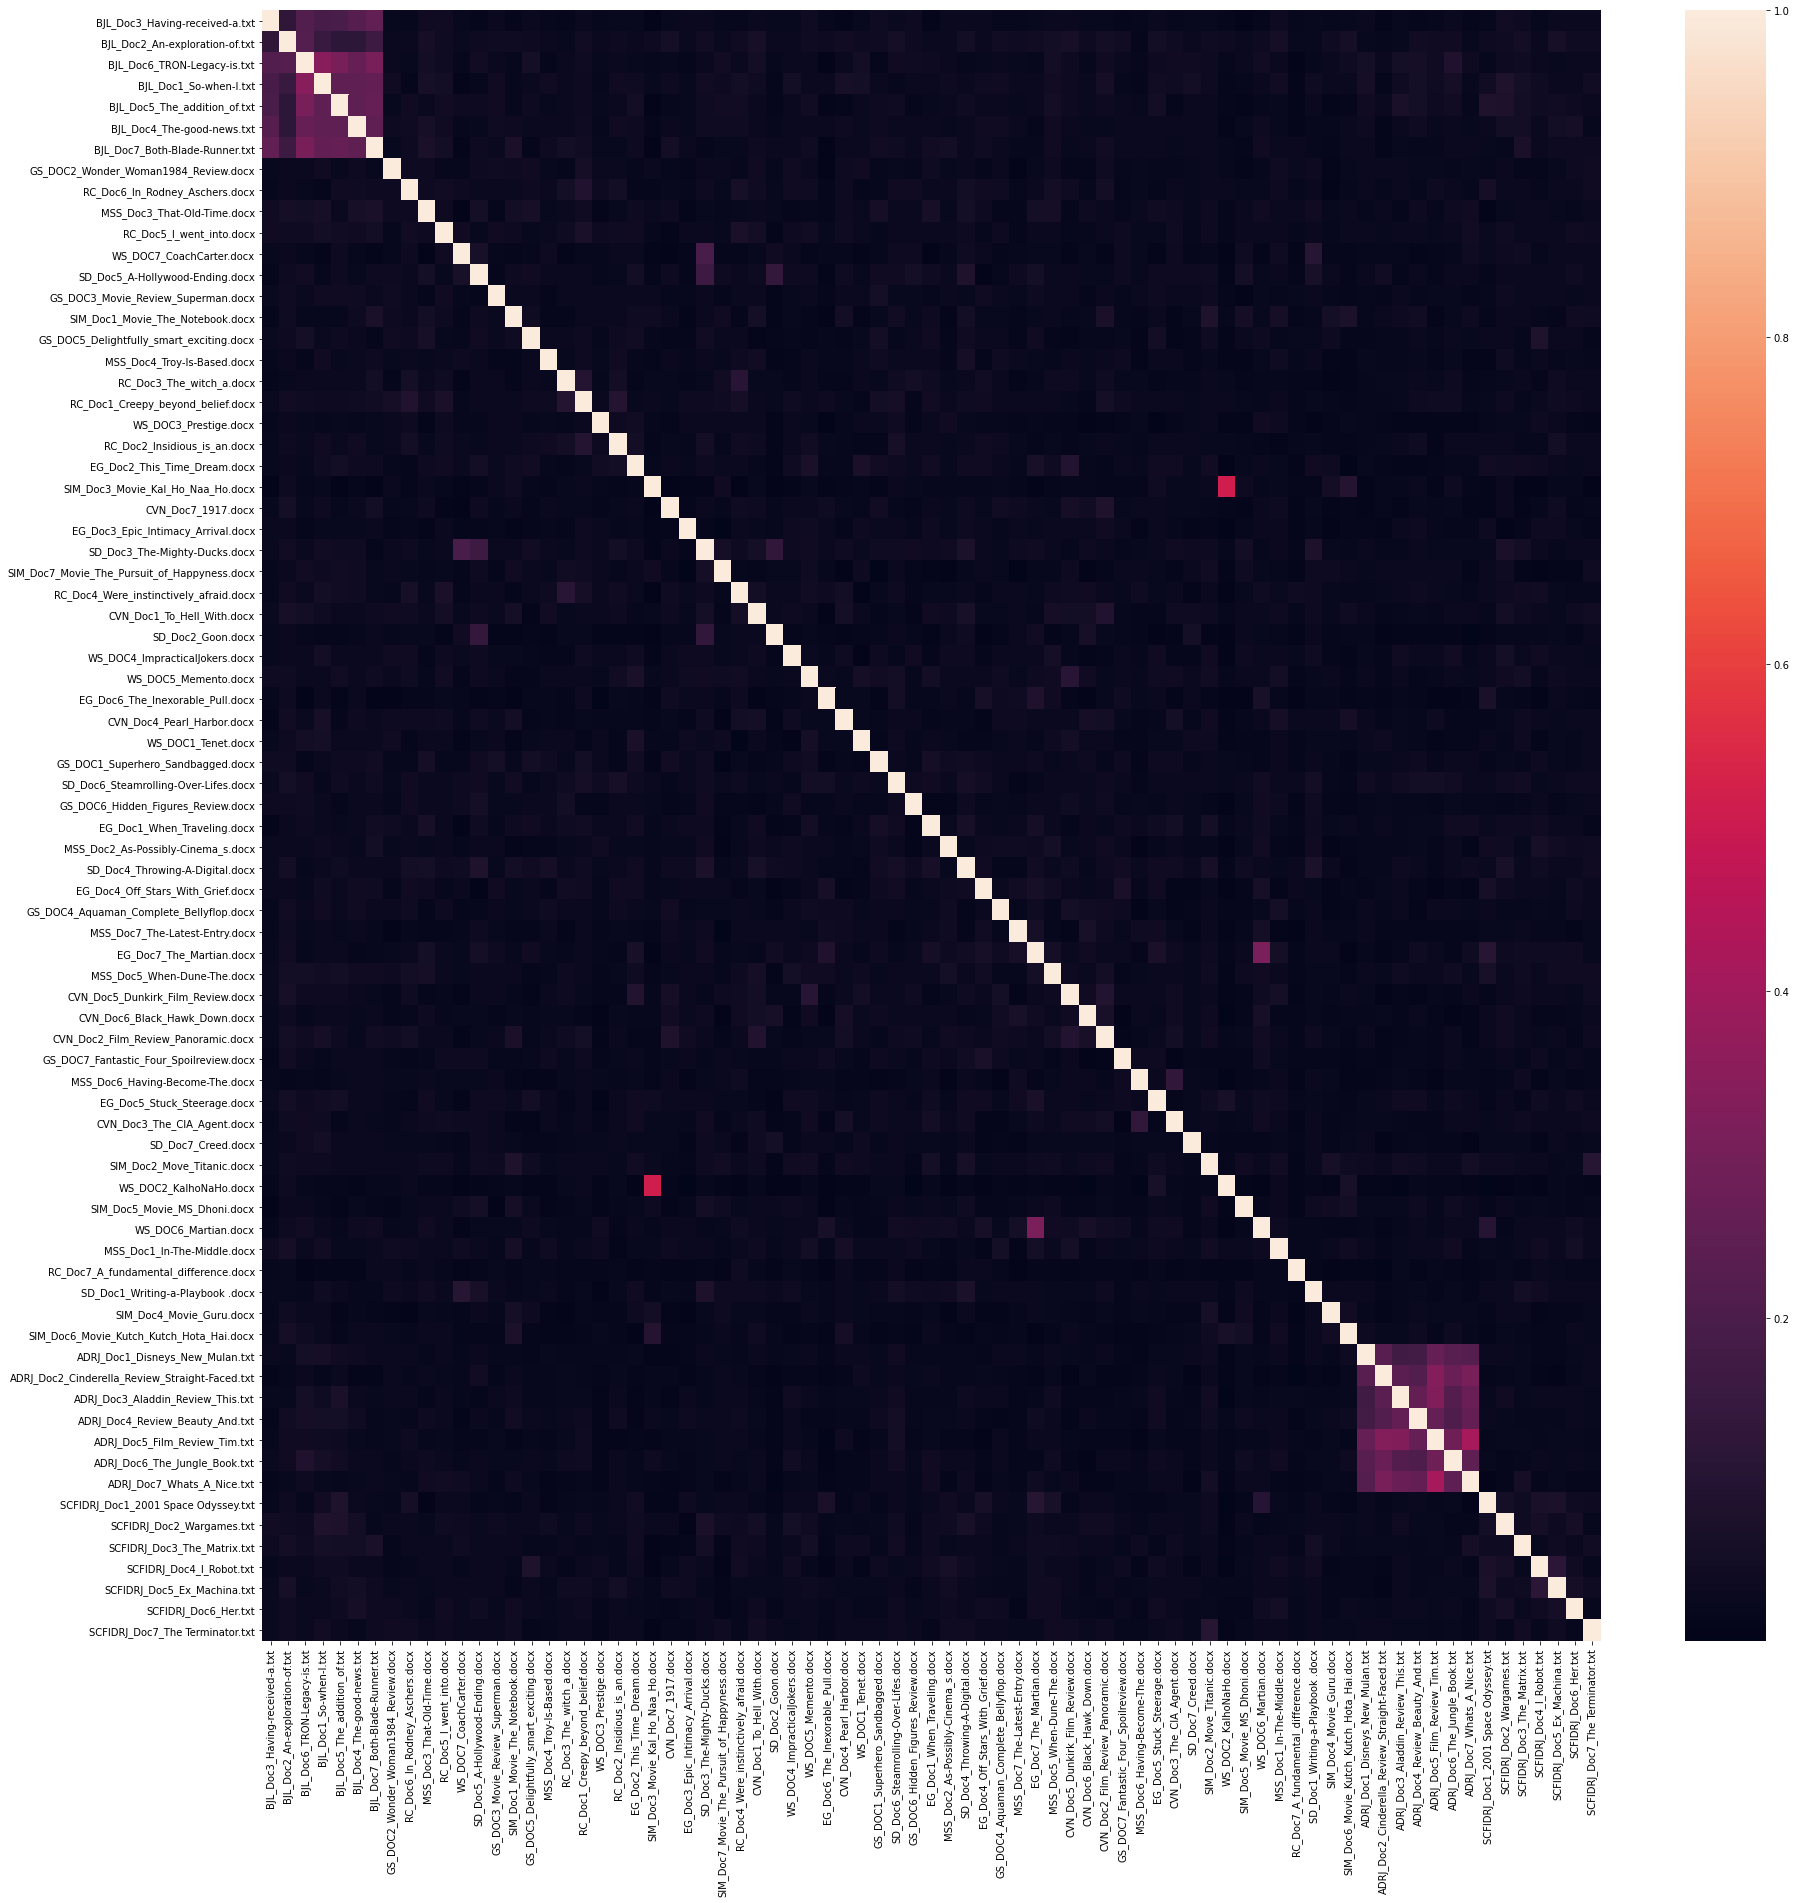

In [24]:
#heatmap of cosine similarity of documents
similarity  = cosine_similarity(df, df)

import seaborn as sns

from matplotlib import pyplot
import seaborn


a4_dims = (30, 30)

fig, ax = pyplot.subplots(figsize=a4_dims)

seaborn.heatmap(ax=ax, data=similarity, xticklabels= titles, yticklabels=titles)




In [25]:
#load class corpus
data=pd.read_csv(r'/Users/paulhuynh/Documents/School/Code_for_SS/2021_Spring_453_Sec56_Class_Corpus-4.csv')

In [26]:
# =============================================================================
# Running functions to (1): process documents, (2) create doc2vec matrix, and
# (3)plotting with TSNE
# =============================================================================
#process documents
titles, final_processed_text, processed_text = process_corpus(data)
print(final_processed_text[0])



having received mysterious signal emanating father arcade investigate following brief press computer terminal locked inside almost atonement lengthy scenesetting legacy opening kosinski kinkily stripped civilian zipped skintight costume rubber glowsticks throw series tronreferencing gladiatorial beginning highvelocity tournament deadly dizzying light cycle chicken whisked slinky heroine quorra quorra played feline innocence olivia wilde warrior program dangerously multitalented talking century literature driving offroad vehicle smashing opponent whisking quorra usher refuge world digital wilderness father kevin zenlike trance learn little kevin backstory advanced program rogue turning fascist state subjugating populace trapping kevin inside world confines kosinski little impatient trapping inherited battle light cycle dispensed early never revisited muddled synapsefrying sequence never topped elsewhere there aerial dogfight attempt dazzle sheer light noise obviously reminiscent analogu

In [27]:
doc2vec_df = run_doc2vec(final_processed_text, processed_text)

labels, tokens, word2vec_model = run_word2vec(processed_text)

print(len(tokens))

2400


<ipython-input-19-84b36ce4840f>:86: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model_w2v[word])


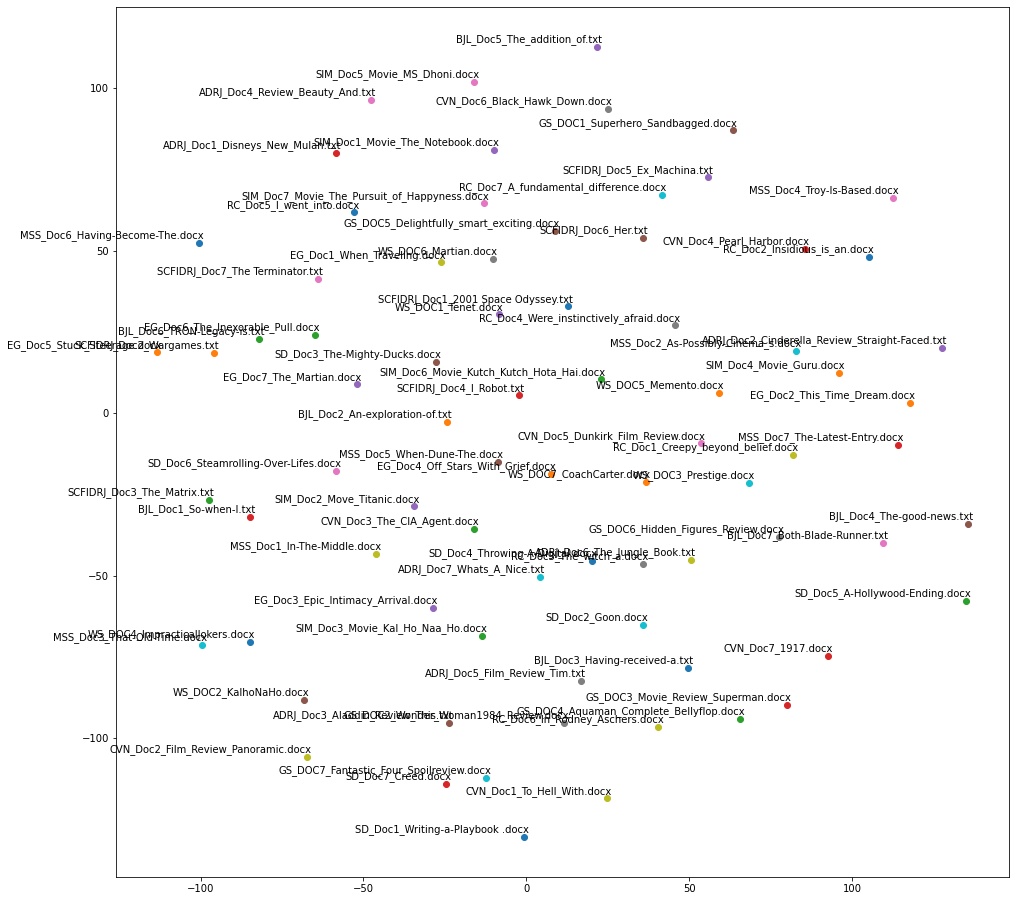

In [28]:
#plot doc2vec via TSNE
plot_doc2vec(doc2vec_df, titles,15)

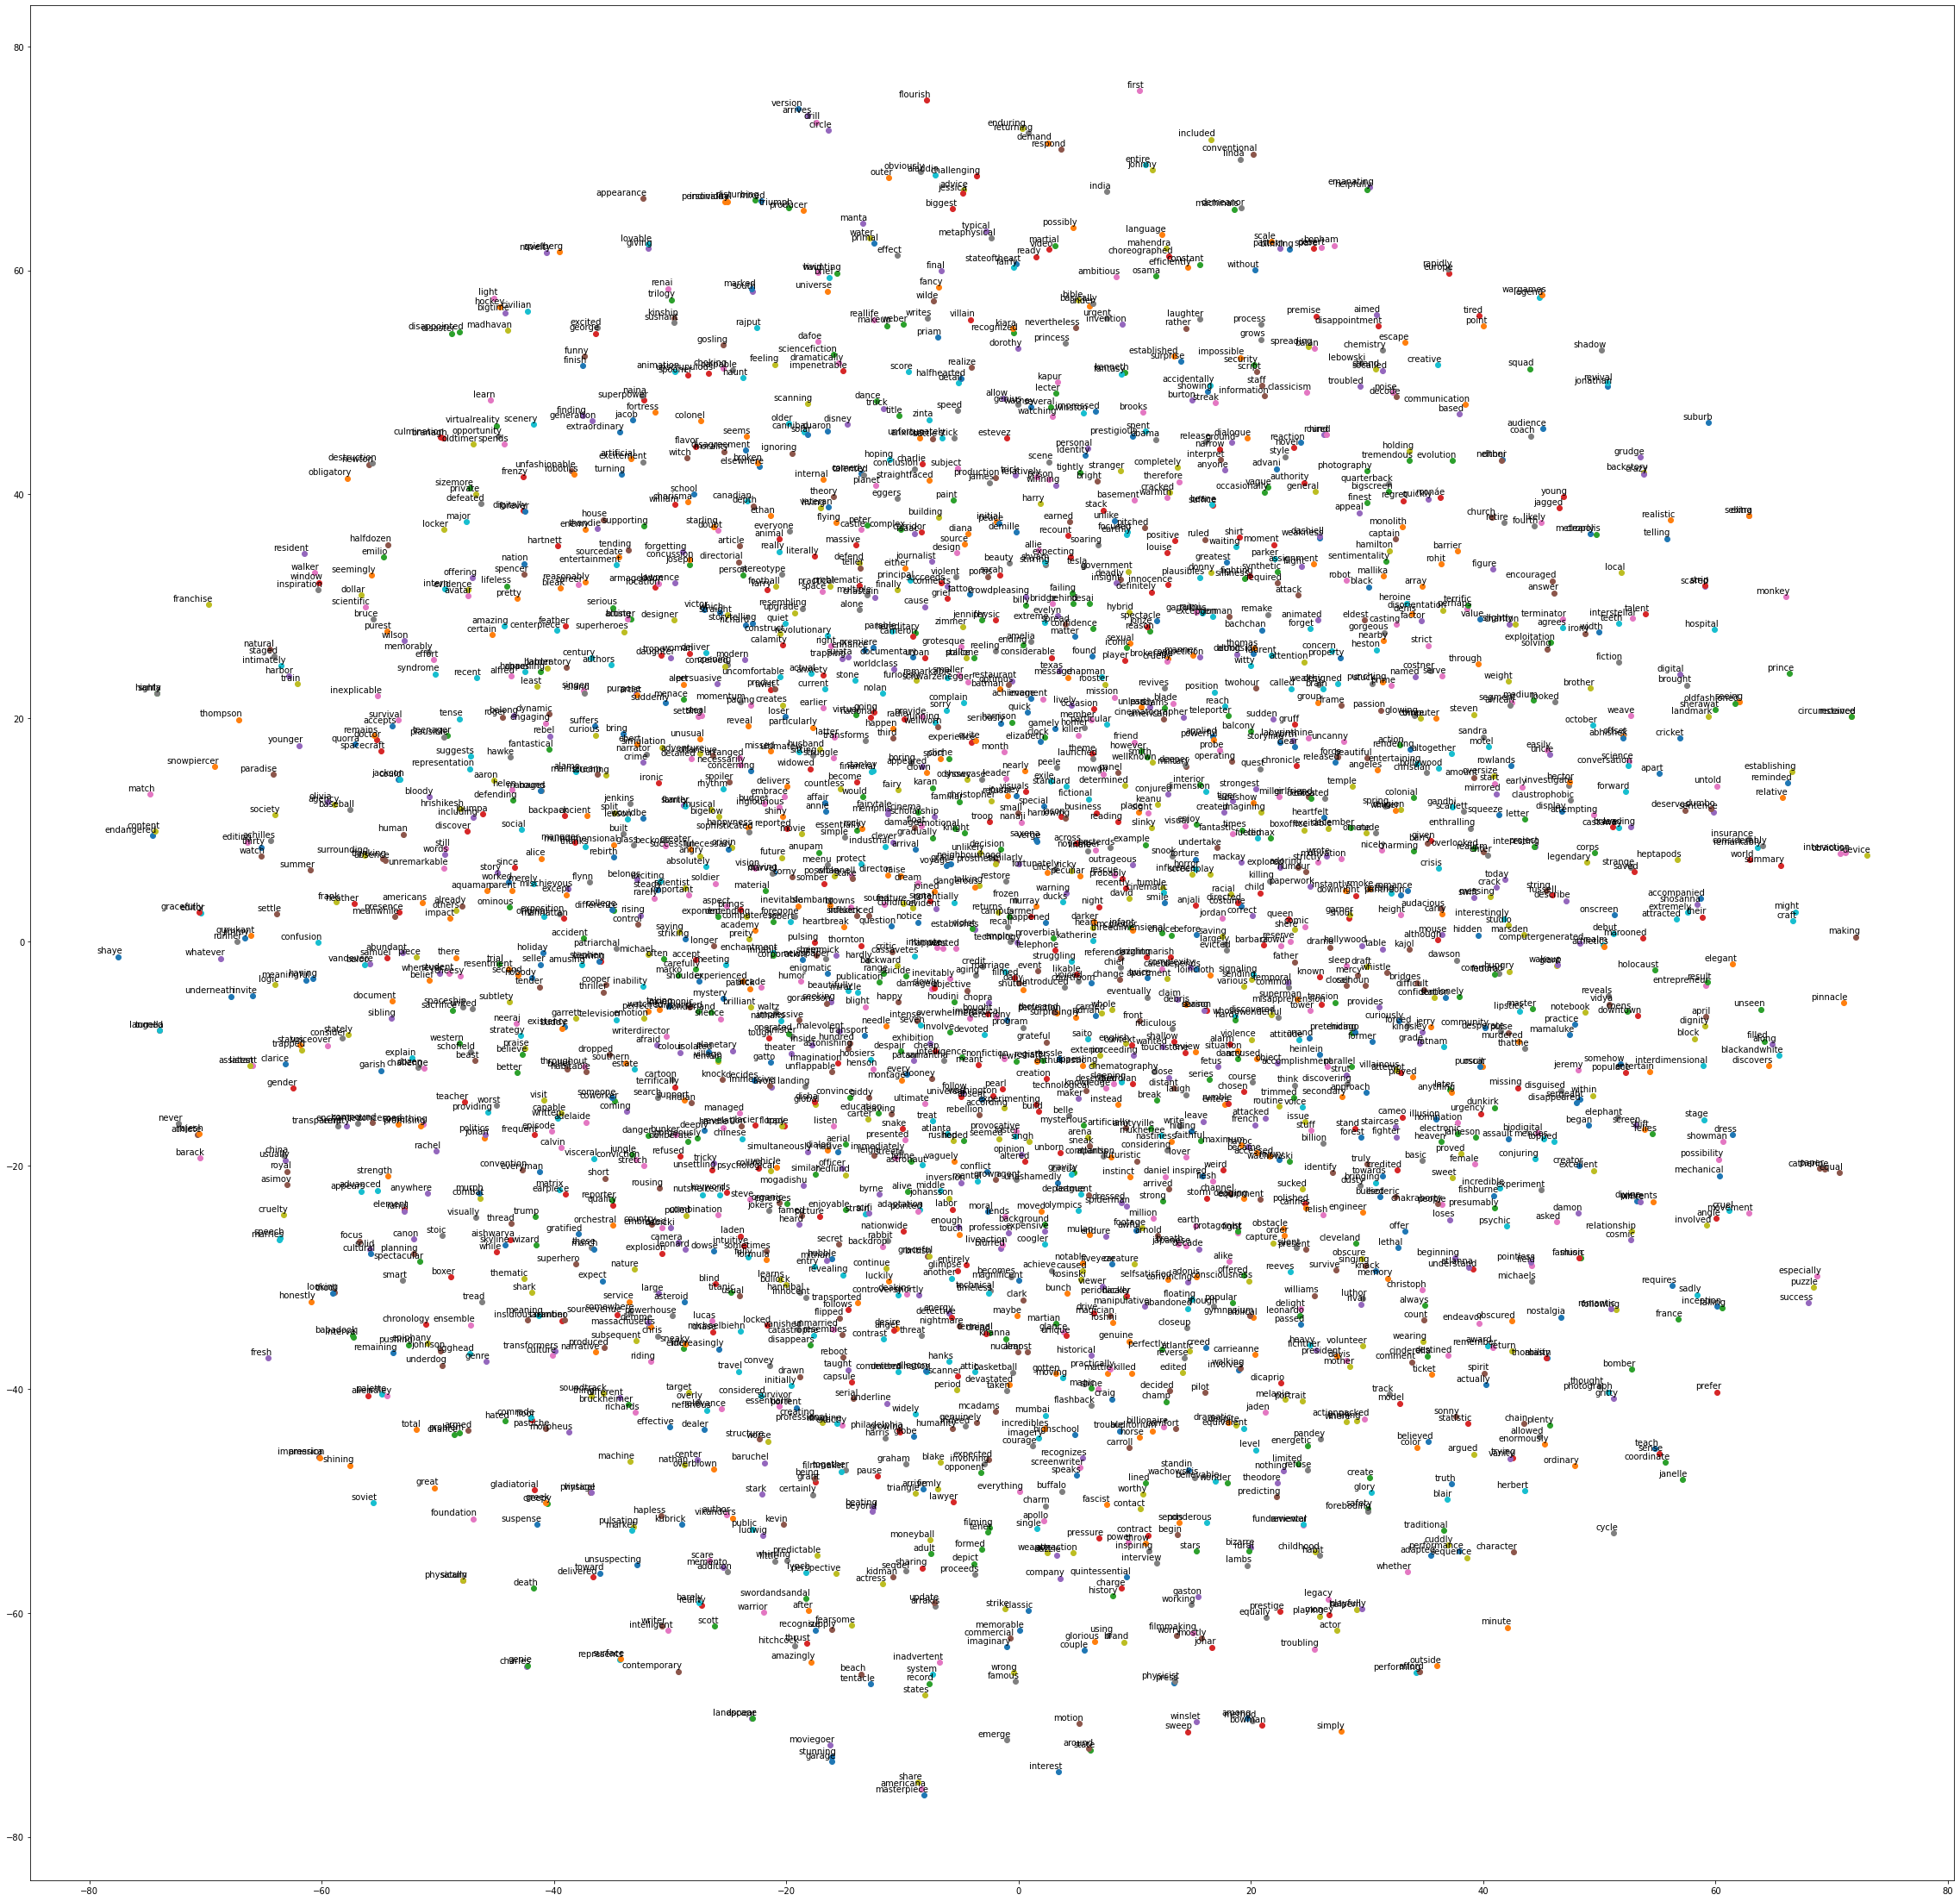

In [29]:
#plot word2vec via TSNE
plot_word2vec(word2vec_model, labels, tokens,20)

In [30]:
#############################################
#Explore K-means clustering of tfidf matrix
#############################################

#############################################
#Calculates tf idf
#Edit ngram range if you like
#############################################
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(stop_words='english', ngram_range = ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

#############################################
#Performs the k-means clustering of the tfidf matrix
#Edit the number of clusters
#############################################
def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=10):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles
        

#############################################
# Run the code
#############################################
tfidf_matrix, terms = tfidf(final_processed_text, titles)
k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=15)

Top terms per cluster:
Cluster 0:
 robot
 spiderman
 diana
 superhero
 incredible
 wonder
 chris
 spooner
 smith
 raimi
Cluster 0 titles: GS_DOC2_Wonder_Woman1984_Review.docx, GS_DOC5_Delightfully_smart_exciting.docx, SIM_Doc7_Movie_The_Pursuit_of_Happyness.docx, GS_DOC1_Superhero_Sandbagged.docx, SCFIDRJ_Doc4_I_Robot.txt, SCFIDRJ_Doc5_Ex_Machina.txt,Cluster 1:
 legacy
 computer
 kevin
 bridges
 flynn
 digital
 father
 world
 soundtrack
 visuals
Cluster 1 titles: BJL_Doc3_Having-received-a.txt, BJL_Doc2_An-exploration-of.txt, BJL_Doc6_TRON-Legacy-is.txt, BJL_Doc1_So-when-I.txt, BJL_Doc5_The_addition_of.txt, BJL_Doc4_The-good-news.txt, BJL_Doc7_Both-Blade-Runner.txt, SIM_Doc6_Movie_Kutch_Kutch_Hota_Hai.docx, SCFIDRJ_Doc2_Wargames.txt,Cluster 2:
 cameron
 titanic
 allie
 novel
 rooster
 coens
 schwarzenegger
 james
 tenet
 herbert
Cluster 2 titles: MSS_Doc3_That-Old-Time.docx, SIM_Doc1_Movie_The_Notebook.docx, WS_DOC5_Memento.docx, WS_DOC1_Tenet.docx, MSS_Doc2_As-Possibly-Cinema_s.docx, 

In [31]:
#############################################
#Explore K-means clustering of doc2vec matrix
#############################################
def doc2vec_with_titles(corpus, processed_text, titles, vector_size = 100):
    #function to created doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    model = Doc2Vec(documents, vector_size=100, window=3, min_count=2, workers=4)

    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

    doc2vec_df=doc2vec_df.reset_index()

    doc_titles={'title': titles}
    t=pd.DataFrame(doc_titles)

    doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

    doc2vec_df=doc2vec_df.drop('index', axis=1)
    return doc2vec_df

def k_means_doc2vec(doc2vec_df, final_processed_text,titles, k = 5):
    
    #this is a funciton to create the k_means outputs using the doc2vec matrics.  Required inputs
    #include the doc2vec matrix, and desired number of clusters.
    doc2vec_k_means=doc2vec_df.drop('title', axis=1)

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_k_means)

    clusters_d2v = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        print("Cluster %d:" % i)
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            print(' %s ' % title, end='\n')
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

doc2vec_model = doc2vec_with_titles(final_processed_text, processed_text,titles)
doc2vec_model.index = titles
k_means_doc2vec(doc2vec_model, final_processed_text,titles, k =15)

Cluster 0:
 GS_DOC2_Wonder_Woman1984_Review.docx 
 GS_DOC7_Fantastic_Four_Spoilreview.docx 
 SD_Doc7_Creed.docx 
 ADRJ_Doc3_Aladdin_Review_This.txt 
Cluster 1:
 MSS_Doc4_Troy-Is-Based.docx 
 RC_Doc2_Insidious_is_an.docx 
 CVN_Doc4_Pearl_Harbor.docx 
Cluster 2:
 MSS_Doc3_That-Old-Time.docx 
 SIM_Doc1_Movie_The_Notebook.docx 
 EG_Doc2_This_Time_Dream.docx 
 WS_DOC5_Memento.docx 
 MSS_Doc2_As-Possibly-Cinema_s.docx 
 SIM_Doc5_Movie_MS_Dhoni.docx 
 SIM_Doc4_Movie_Guru.docx 
 ADRJ_Doc4_Review_Beauty_And.txt 
Cluster 3:
 GS_DOC1_Superhero_Sandbagged.docx 
 RC_Doc7_A_fundamental_difference.docx 
 SCFIDRJ_Doc5_Ex_Machina.txt 
 SCFIDRJ_Doc6_Her.txt 
Cluster 4:
 RC_Doc5_I_went_into.docx 
 WS_DOC7_CoachCarter.docx 
 GS_DOC5_Delightfully_smart_exciting.docx 
 RC_Doc1_Creepy_beyond_belief.docx 
 WS_DOC3_Prestige.docx 
 SD_Doc3_The-Mighty-Ducks.docx 
 SIM_Doc7_Movie_The_Pursuit_of_Happyness.docx 
 WS_DOC1_Tenet.docx 
 EG_Doc1_When_Traveling.docx 
 EG_Doc7_The_Martian.docx 
 CVN_Doc6_Black_Hawk_Down.

In [32]:
#implementation of silhouette score to measure the most optimal number of clusters

k_list = [2, 5, 7, 10]

#silhoutte score list
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)
    
    


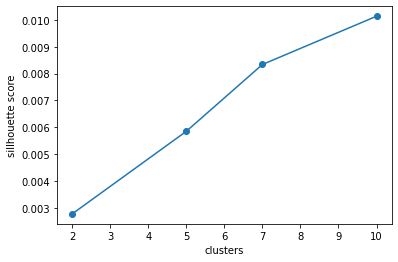

In [33]:
#plot silhouette scores in chart

import matplotlib.pyplot as plt


plt.scatter(k_list, sil_scores)
plt.plot(k_list, sil_scores)
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()